In [1]:
"""
write a code that read the png files
"""
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as func
from tqdm.notebook import tqdm
from scipy.ndimage import maximum_filter
from scipy.ndimage import gaussian_filter

from PIL import Image
import glob



graph TD
    A1([Input]) --> B1(DoubleConv, 1 to 64 channels)
    B1 --> B2(Down, 64 to 128 channels)
    B2 --> B3(Down, 128 to 256 channels)
    B3 --> B4(Down, 256 to 512 channels)
    B4 --> B5(Down, 512 to 1024 channels)
    B5 --> C1(Up, 1024 to 512 channels)
    C1 --> C2(Up, 512 to 256 channels)
    C2 --> C3(Up, 256 to 128 channels)
    C3 --> C4(Up, 128 to 64 channels)
    C4 --> D1(OutConv, 64 to 1 class)
    D1 --> E1([Output])
    
    %% Skipping connections
    B1 -->|Skip| C4
    B2 -->|Skip| C3
    B3 -->|Skip| C2
    B4 -->|Skip| C1


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data_train = {}
data_valid = {}
target_train = {}
target_valid = {}
train_valid_split = 0.5

"""
The imagines with name 01 at last are the ones with the noise
those we will use to train the model
At the meantime, the same name imagines without 01 at last are the ones without noise
"""
for data in glob.glob('testdata/*'):
    if '01.png' not in data:
        continue

    if np.random.rand() < train_valid_split:
        data_train[data] = np.array(Image.open(data))
        target_train[data] = np.array(Image.open(data.replace('01.png', '02.png')))
    else: 
        data_valid[data] = np.array(Image.open(data))
        target_valid[data] = np.array(Image.open(data.replace('01.png', '02.png')))




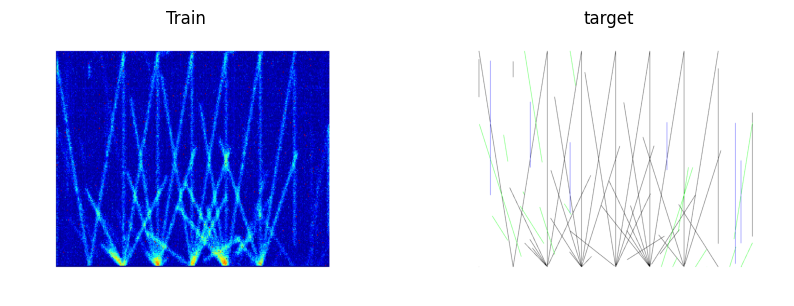

testdata/run_004_image_01.png (875, 1167, 3)
testdata/run_004_image_01.png (875, 1167, 3)


In [4]:
"""
Show the images
"""
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(data_train[list(data_train.keys())[0]])
ax[0].set_title('Train')
ax[0].axis('off')
ax[1].imshow(target_train[list(target_train.keys())[0]])
ax[1].set_title('target')
ax[1].axis('off')
plt.show()

for key, value in data_train.items():
    print(key, value.shape)
    break
for key, value in target_train.items():
    print(key, value.shape)
    break


In [5]:
"""
crop the white background of each image, there are three channels
"""
def crop_background(img):
    mask = img.sum(axis=-1) != 255 
    rows = np.where(mask.any(axis=1))[0]
    cols = np.where(mask.any(axis=0))[0]
    img = img[rows.min(): rows.max() + 1, cols.min(): cols.max() + 1]
    img = img.mean(axis=-1)
    return img

def crop_index(img):
    mask = img.sum(axis=-1) != 255 * 3
    rows = np.where(mask.any(axis=1))[0]
    cols = np.where(mask.any(axis=0))[0]
    return rows.min(), rows.max() + 1, cols.min(), cols.max() + 1

def crop_by_index(img, index):
    return img[index[0]: index[1], index[2]: index[3]]

""" 
change the image to the gray scale
"""

def to_gray(img):
    return img.mean(axis=-1)

"""
negative the image and make the image black and white
"""
def to_bw(img, threshold=20):
    img = img.mean(axis=-1)
    img = 255 - img
    img[img < threshold] = 0
    img[img >= threshold] = 255
    return img
    


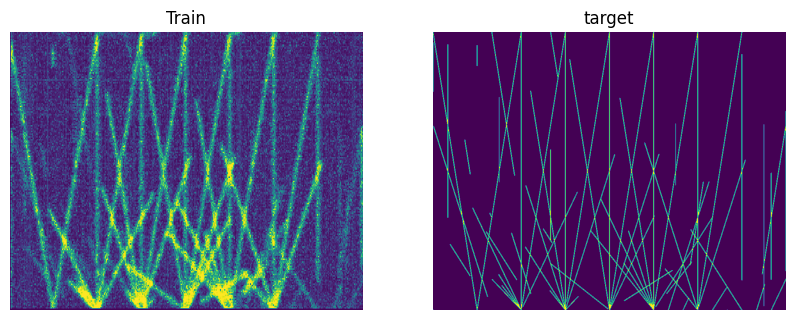

testdata/run_004_image_01.png (713, 904)
testdata/run_004_image_01.png (713, 904)


In [6]:
crop_ind = crop_index(data_train[list(data_train.keys())[0]])

data_train = {k: crop_by_index(v, crop_ind) for k, v in data_train.items()}
data_valid = {k: crop_by_index(v, crop_ind) for k, v in data_valid.items()}
target_train = {k: crop_by_index(v, crop_ind) for k, v in target_train.items()}
target_valid = {k: crop_by_index(v, crop_ind) for k, v in target_valid.items()}


data_train = {k: to_gray(v) for k, v in data_train.items()}
data_valid = {k: to_gray(v) for k, v in data_valid.items()}
target_train = {k: to_bw(v) for k, v in target_train.items()}
target_valid = {k: to_bw(v) for k, v in target_valid.items()}

""" 
show one train image
"""

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(data_train[list(data_train.keys())[0]])
ax[0].set_title('Train')
ax[0].axis('off')
ax[1].imshow(target_train[list(target_train.keys())[0]])
ax[1].set_title('target')
ax[1].axis('off')
plt.show()

"""
get the shape of the data
"""
for key, value in data_train.items():
    print(key, value.shape)
    break

"""
get the shape of the validation data, it should be the same
"""
for key, value in target_train.items():
    print(key, value.shape)
    break


In [15]:
import cv2
def linear_contrast_stretch(image):
    # Find the minimum and maximum pixel values
    minVal = np.min(image)
    maxVal = np.max(image)
    # Apply the linear stretch formula
    stretched = 255 * (image - minVal) / (maxVal - minVal)
    return stretched.astype(np.float32)

def gamma_stretch(image, gamma=1.0):

    # Convert image to float32 for precision, normalize to the range 0 to 1
    normalized = image.astype(np.float32) / 255.0
    # Apply gamma correction
    corrected = np.power(normalized, gamma)
    # Convert back to an float32 image scaled to 0-255
    gamma_corrected = corrected * 255.0
    return gamma_corrected.astype(np.float32)

def logarithmic_stretching(image):
    # Convert image to float32 to avoid overflow, and add a small value to avoid log(0)
    img_float = np.float32(image) + 1.0
    # Apply logarithmic stretch
    log_stretch = np.log(img_float) * (255 / np.log(1 + np.max(img_float)))
    
    return log_stretch.astype(np.float32)

def thicken_lines(img, kernel_size=(4,4), iterations=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    dilated_img = cv2.dilate(img, kernel, iterations=iterations)
    return dilated_img

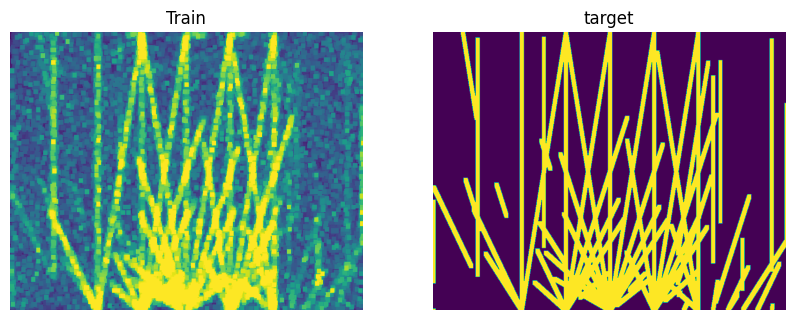

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(thicken_lines(data_train[list(data_train.keys())[1]]))
ax[0].set_title('Train')
ax[0].axis('off')
ax[1].imshow(thicken_lines(target_train[list(target_train.keys())[1]]))
ax[1].set_title('target')
ax[1].axis('off')
plt.show()